# Multiple Stripe Analysis (MSA) for Single Degree of Freedom (SDOF) Oscillators

In this method, a single degree of freedom (SDOF) model of each structure is subjected to non-linear time history analysis using a suite of ground motion records scaled to multple stripes of intensity measure. The displacements of the SDOF due to each ground motion record are used as input to determine the distribution of buildings in each damage state for each level of ground motion intensity. A regression algorithm is then applied to derive the fragility model.

The figure below illustrates a fragility model developed using this method.

<img src="../../../../figures/NLTHA_SDOF.png" width="400" align="middle">

**Note**: To run the code in a cell:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

In [7]:
import MSA_on_SDOF
from rmtk.vulnerability.common import utils
import numpy as np
%matplotlib inline 

---
###Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format described in the [RMTK manual](../../../../rmtk-docs.pdf).

Please provide the location of the file containing the capacity curves using the parameter `capacity_curves_file`.

If the User wants to specify the cyclic hysteretic behaviour of the SDOF system, please input the path of the file where the hysteretic parameters are contained, using the variable `sdof_hysteresis`. The parameters should be defined according to the format described in the [RMTK manual](../../../../rmtk-docs.pdf). If instead default parameters want to be assumed, please set the `sdof_hysteresis` variable to `"Default"`

In [8]:
capacity_curves_file = "../../../../../rmtk_data/capacity_curve_Sa-Sd.csv"
#sdof_hysteresis = "Default"
sdof_hysteresis = "../../../../../rmtk_data/pinching_parameters.csv"

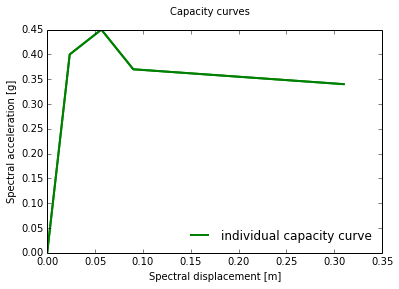

In [9]:
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
if sdof_hysteresis is not "Default":
    from read_pinching_parameters import read_parameters
    hysteresis = read_parameters(sdof_hysteresis)
else:
    hysteresis = {}; hysteresis['type'] = "Default"

### Load ground motion records
For what concerns the ground motions to be used in th Multiple Stripe Analysis the following inputs are required:
 1. `gmrs_folder`: path to the folder containing the ground motion records to be used in the analysis. Each accelerogram needs to be in a separate CSV file as described in the [RMTK manual](../../../../rmtk-docs.pdf).
 2. `record_scaled_folder`. In this folder there should be a csv file for each Intensity Measure bin selected for the MSA, containing the names of the records that should be scaled to that IM bin, and the corresponding scaling factors. An example of this type of file is provided in the [RMTK manual](../../../../rmtk-docs.pdf).
 3. `no_bins`: number of Intensity Measure bins.
 4. `no_rec_bin`: number of records per bin

If the user wants to plot acceleration, displacement and velocity response spectra, the function `utils.plot_response_spectra(gmrs, minT, maxT)` should be un-commented. The parameters `minT` and `maxT` are used to define the period bounds when plotting the spectra for the provided ground motion fields.

In [10]:
gmrs_folder = "../../../../../rmtk_data/SYMBAD_txt"
minT, maxT = 0.1, 2.0

gmrs = utils.read_gmrs(gmrs_folder)
#utils.plot_response_spectra(gmrs, minT, maxT)

no_bins = 10
no_rec_bin = 30
record_scaled_folder = "../../../../../rmtk_data/Records_scaled"

###Load damage state thresholds

Please provide the path to your damage model file using the parameter `damage_model_file` in the cell below.

Currently the user can provide `spectral displacement`, `capacity curve dependent` and `interstorey drift` damage model type.
If the damage model type is `interstorey drift` the user has to input interstorey drift values of the MDOF system. The user can then provide the pushover curve in terms of `Vb-dfloor` to be able to convert interstorey drift limit states to roof displacements and spectral displacements of the SDOF system, otherwise a linear relationship is assumed. In the former case please provide the path to the pushover curve input file in the parameters `pushover_file`, in the latter set `pushover_file="Default"`

In [11]:
damage_model_file = "../../../../../rmtk_data/damage_model_ISD.csv"
damage_model = utils.read_damage_model(damage_model_file)

pushover_file = "../../../../../rmtk_data/capacity_curve_Vb-dfloor.csv"

if pushover_file is not "Default":
    pushover_curves = utils.read_capacity_curves(pushover_file)
else: pushover_curves = capacity_curves

###Obtain the damage probability matrix

The following parameters need to be defined in the cell below in order to calculate the damage probability matrix:
1. `damping_ratio`: This parameter defines the damping ratio for the structure.
2. `degradation`: This boolean parameter should be set to `True` or `False` to specify whether structural degradation should be considered in the analysis or not.

In [13]:
damping_ratio = 0.05
degradation = False

msa = {}; msa['n. bins']=no_bins; msa['records per bin']=no_rec_bin; msa['input folder']=record_scaled_folder
PDM, Sds, IML_info = MSA_on_SDOF.calculate_fragility(capacity_curves, pushover_curves, hysteresis, msa, gmrs, 
                                                      damage_model, damping_ratio, degradation)

100%
records_target1.csv
gmr n. 1 max disp. = 0.00804013 DS = 0
gmr n. 2 max disp. = 0.0140219 DS = 0
gmr n. 3 max disp. = 0.0127883 DS = 0
gmr n. 4 max disp. = 0.01904 DS = 0
gmr n. 5 max disp. = 0.0353106 DS = 0
gmr n. 6 max disp. = 0.0455577 DS = 0
gmr n. 7 max disp. = 0.0163533 DS = 0
gmr n. 8 max disp. = 0.0198874 DS = 0
gmr n. 9 max disp. = 0.0217917 DS = 0
gmr n. 10 max disp. = 0.0314932 DS = 0
gmr n. 11 max disp. = 0.0140049 DS = 0
gmr n. 12 max disp. = 0.0333681 DS = 0
gmr n. 13 max disp. = 0.00869221 DS = 0
gmr n. 14 max disp. = 0.0307809 DS = 0
gmr n. 15 max disp. = 0.0217426 DS = 0
gmr n. 16 max disp. = 0.0265591 DS = 0
gmr n. 17 max disp. = 0.0352223 DS = 0
gmr n. 18 max disp. = 0.0330807 DS = 0
gmr n. 19 max disp. = 0.0260618 DS = 0
gmr n. 20 max disp. = 0.0287676 DS = 0
gmr n. 21 max disp. = 0.0308829 DS = 0
gmr n. 22 max disp. = 0.0259651 DS = 0
gmr n. 23 max disp. = 0.0328968 DS = 0
gmr n. 24 max disp. = 0.0221919 DS = 0
gmr n. 25 max disp. = 0.0223703 DS = 0
gmr n. 26

### Fit lognormal CDF fragility curves

The following parameters need to be defined in the cell below in order to fit lognormal CDF fragility curves to the damage probability matrix obtained above:
1. `IMT`: This parameter specifies the intensity measure type to be used. Currently supported options are `"PGA"`, `"Sa"`,`"Sd"` and `"HI"` (Housner Intensity).
2. `period`: This parameter defines the period for which a spectral intensity measure should be computed. If Housner Intensity is selected as intensity measure a range of periods should be defined instead (for example `T=np.arange(0.3,3.61,0.01)`).
3. `regression_method`: This parameter defines the regression method to be used for estimating the parameters of the fragility functions. The valid options are `"least squares"` and `"max likelihood"`.

In [14]:
import MSA_post_processing

IMT = "HI"
T = np.arange(0.3,3.6+0.005,0.005)
regression_method = "max likelihood"

fragility_model = MSA_post_processing.calculate_fragility_model(PDM,gmrs,IML_info,IMT,msa,damage_model,
                                                                        T,damping_ratio, regression_method)

Optimization terminated successfully.
         Current function value: 11.575248
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 12.114309
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: 16.147135
         Iterations: 71
         Function evaluations: 131


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/distributions.py:7184: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/distributions.py:7184: RuntimeWarning: invalid value encountered in less_equal
  return (n >= 0) & (p >= 0) & (p <= 1)


### Plot fragility functions

The following parameters need to be defined in the cell below in order to plot the lognormal CDF fragility curves obtained above:
* `minIML` and `maxIML`: These parameters define the limits of the intensity measure level for plotting the functions

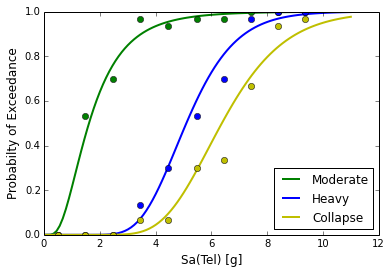

In [16]:
minIML, maxIML = 0.01, 11
utils.plot_fragility_model(fragility_model, minIML, maxIML)


### Save fragility functions
 
The derived parametric fragility functions can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
 1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
 2. `minIML` and `maxIML`: These parameters define the bounds of applicability of the functions.
 3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [19]:
taxonomy = "sdof"
minIML, maxIML = 0.01, 10.00
output_type = "csv"

In [20]:
utils.save_mean_fragility(taxonomy, fragility_model, minIML, maxIML, output_type)